In [2]:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
global_temp = pd.read_csv('data/GlobalTemperatures.csv')

In [4]:
global_temp = global_temp[['dt', 'LandAverageTemperature']]

global_temp['dt'] = pd.to_datetime(global_temp['dt'])
global_temp['year'] = global_temp['dt'].map(lambda x: x.year)
global_temp['month'] = global_temp['dt'].map(lambda x: x.month)

def get_season(month):
    if month >= 3 and month <= 5:
        return 'spring'
    elif month >= 6 and month <= 8:
        return 'summer'
    elif month >= 9 and month <= 11:
        return 'autumn'
    else:
        return 'winter'
    
min_year = global_temp['year'].min()
max_year = global_temp['year'].max()
years = range(min_year, max_year + 1)

global_temp['season'] = global_temp['month'].apply(get_season)

spring_temps = []
summer_temps = []
autumn_temps = []
winter_temps = []

for year in years:
    curr_years_data = global_temp[global_temp['year'] == year]
    spring_temps.append(curr_years_data[curr_years_data['season'] == 'spring']['LandAverageTemperature'].mean())
    summer_temps.append(curr_years_data[curr_years_data['season'] == 'summer']['LandAverageTemperature'].mean())
    autumn_temps.append(curr_years_data[curr_years_data['season'] == 'autumn']['LandAverageTemperature'].mean())
    winter_temps.append(curr_years_data[curr_years_data['season'] == 'winter']['LandAverageTemperature'].mean())

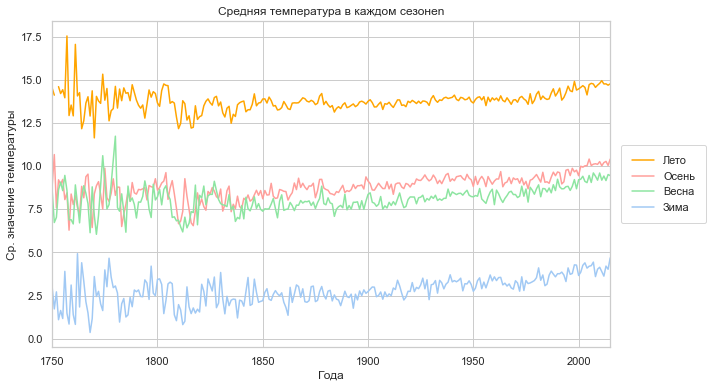

In [5]:
sns.set(style="whitegrid")
sns.set_color_codes("pastel")
f, ax = plt.subplots(figsize=(10, 6))

plt.plot(years, summer_temps, label='Лето', color='orange')
plt.plot(years, autumn_temps, label='Осень', color='r')
plt.plot(years, spring_temps, label='Весна', color='g')
plt.plot(years, winter_temps, label='Зима', color='b')

plt.xlim(min_year, max_year)

ax.set_ylabel('Ср. значение температуры')
ax.set_xlabel('Года')
ax.set_title('Средняя температура в каждом сезонеn')
legend = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=True, borderpad=1, borderaxespad=1)

In [6]:
cities = pd.read_csv('data/GlobalLandTemperaturesByCity.csv', sep=",")
mos = cities.loc[cities['City'] == 'Kaliningrad', ['dt','AverageTemperature']]
mos.columns = ['Date','Temp']
mos['Date'] = pd.to_datetime(mos['Date'])
mos.reset_index(drop=True, inplace=True)
mos.set_index('Date', inplace=True)

mos = mos.loc['1900':'2013-01-01']
mos = mos.asfreq('M', method='bfill')
mos.head()

,Temp
Date,
1900-01-31,-1.514
1900-02-28,-1.419
1900-03-31,3.069
1900-04-30,6.756
1900-05-31,12.402


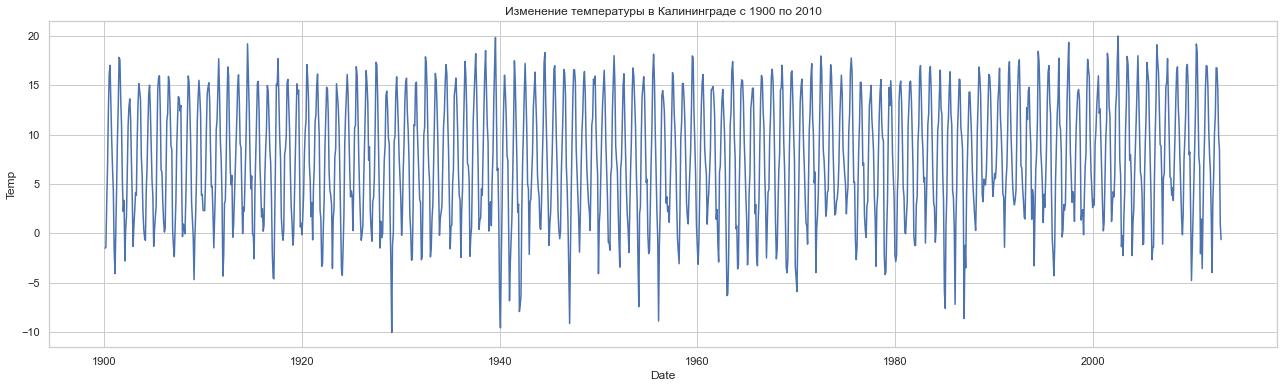

In [7]:
plt.figure(figsize=(22,6))
sns.lineplot(x=mos.index, y=mos['Temp'])
plt.title('Изменение температуры в Калининграде с 1900 по 2010')
plt.show()

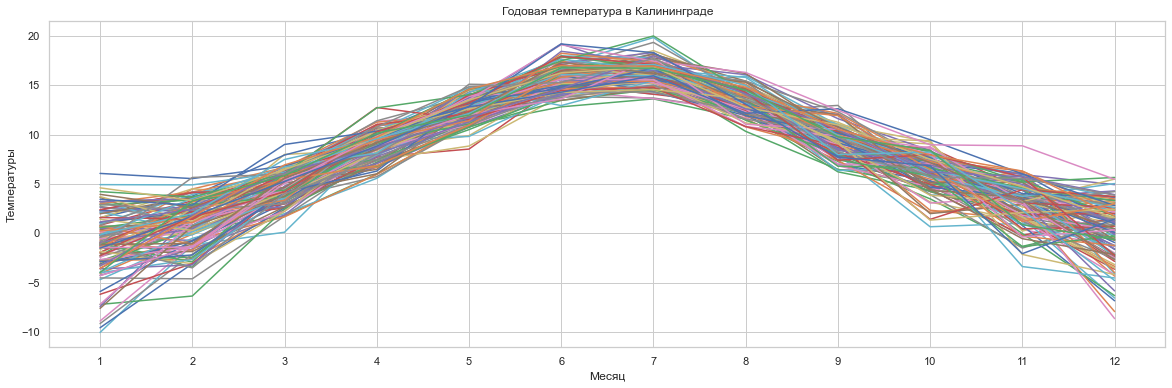

In [8]:
mos['month'] = mos.index.month
mos['year'] = mos.index.year
pivot = pd.pivot_table(mos, values='Temp', index='month', columns='year', aggfunc='mean')
pivot.plot(figsize=(20,6))
plt.title('Годовая температура в Калининграде')
plt.xlabel('Месяц')
plt.ylabel('Температуры')
plt.xticks([x for x in range(1,13)])
plt.legend().remove()
plt.show()

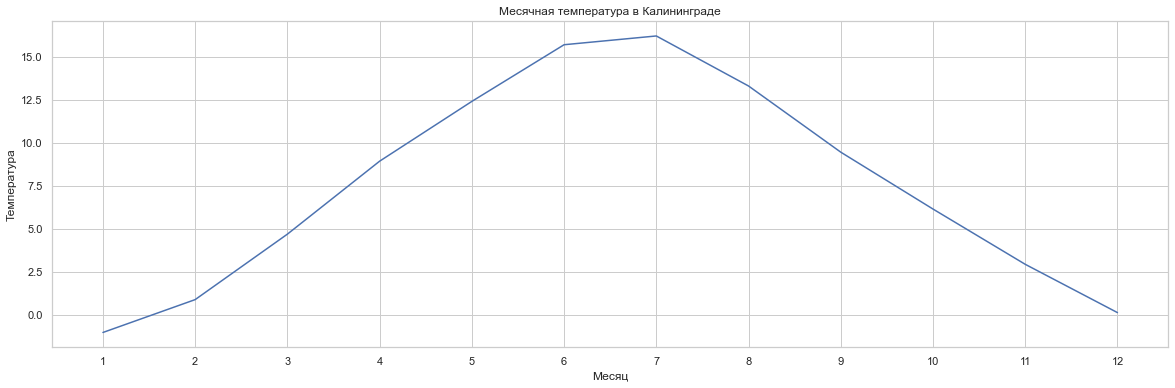

In [9]:
monthly_seasonality = pivot.mean(axis=1)
monthly_seasonality.plot(figsize=(20,6))
plt.title('Месячная температура в Калининграде')
plt.xlabel('Месяц')
plt.ylabel('Температура')
plt.xticks([x for x in range(1,13)])
plt.show()

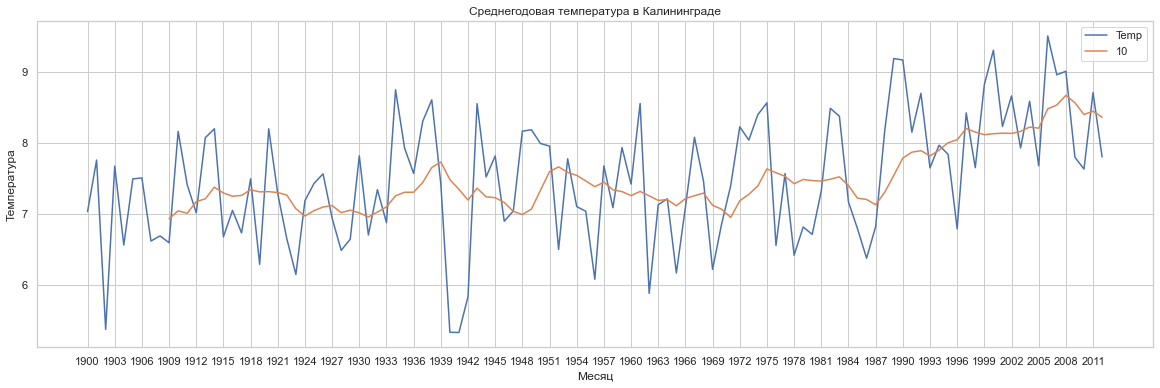

In [10]:
year_avg = pd.pivot_table(mos, values='Temp', index='year', aggfunc='mean')
year_avg['10'] = year_avg['Temp'].rolling(10).mean()
year_avg[['Temp','10']].plot(figsize=(20,6))
plt.title('Среднегодовая температура в Калининграде')
plt.xlabel('Месяц')
plt.ylabel('Температура')
plt.xticks([x for x in range(1900,2012,3)])
plt.show()

In [11]:
train = mos[:-60].copy()
val = mos[-60:-12].copy()
test = mos[-12:].copy()

In [12]:
baseline = val['Temp'].shift()
baseline.dropna(inplace=True)
baseline.head()

Date
2008-02-29     4.602
2008-03-31     3.314
2008-04-30     6.459
2008-05-31     9.661
2008-06-30    13.495
Freq: M, Name: Temp, dtype: float64

In [13]:
def measure_rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true,y_pred))

rmse_base = measure_rmse(val.iloc[1:,0],baseline)
print(f'RMSE baseline, которую мы будем пытаться уменьшить, составляет {round(rmse_base,4)} градус Цельсия')

RMSE baseline, которую мы будем пытаться уменьшить, составляет 3.9285 градус Цельсия


In [14]:
def check_stationarity(y, lags_plots=48, figsize=(22,8)):
    "Use Series as parameter"
    
    # Creating plots of the DF
    y = pd.Series(y)
    fig = plt.figure()

    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 3), (1, 0))
    ax3 = plt.subplot2grid((3, 3), (1, 1))
    ax4 = plt.subplot2grid((3, 3), (2, 0), colspan=2)

    y.plot(ax=ax1, figsize=figsize)
    ax1.set_title('Изменения температуры в Калининграде')
    plot_acf(y, lags=lags_plots, zero=False, ax=ax2);
    plot_pacf(y, lags=lags_plots, zero=False, ax=ax3);
    sns.distplot(y, bins=int(sqrt(len(y))), ax=ax4)
    ax4.set_title('Диаграмма распределения')

    plt.tight_layout()
    
    print('Результаты теста:')
    adfinput = adfuller(y)
    adftest = pd.Series(adfinput[0:4], index=['Статистика теста','p-величина','Использовано лагов','Количество использованных наблюдений'])
    adftest = round(adftest,4)
    
    for key, value in adfinput[4].items():
        adftest["Критическое значение (%s)"%key] = value.round(4)
        
    print(adftest)
    
    if adftest[0].round(2) < adftest[5].round(2):
        print('\nСтатистика теста ниже критического значения 5%.\nРяд стационарна')
    else:
        print("\nСтатистика теста выше критического значения 5%.\nРяд не стационарна")

Результаты теста:
Статистика теста                          -4.5945
p-величина                                 0.0001
Использовано лагов                        23.0000
Количество использованных наблюдений    1272.0000
Критическое значение (1%)                 -3.4355
Критическое значение (5%)                 -2.8638
Критическое значение (10%)                -2.5680
dtype: float64

Статистика теста ниже критического значения 5%.
Ряд стационарна


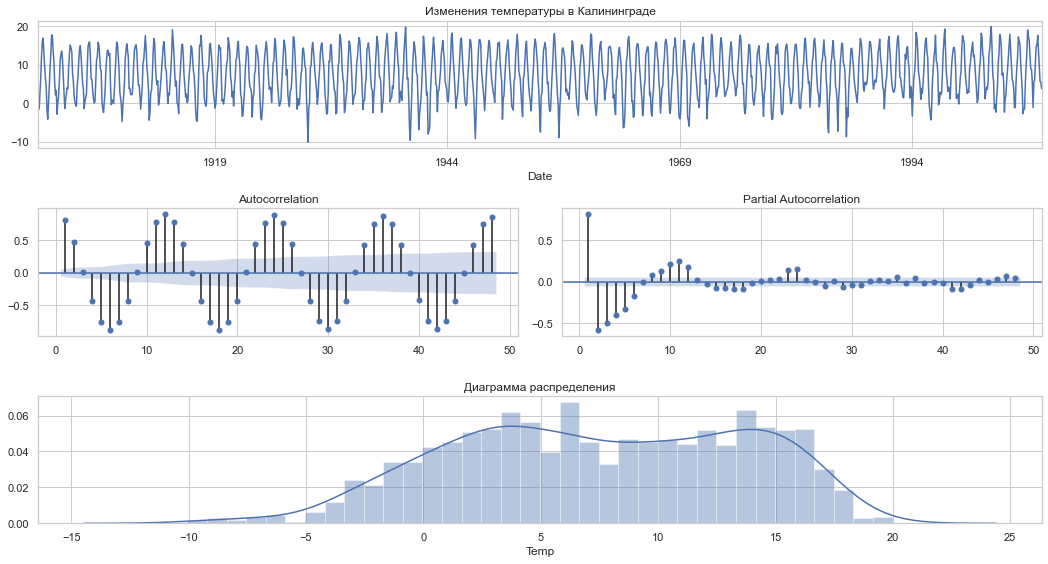

In [15]:
check_stationarity(train['Temp'])

Результаты теста:
Статистика теста                         -11.1230
p-величина                                 0.0000
Использовано лагов                        23.0000
Количество использованных наблюдений    1260.0000
Критическое значение (1%)                 -3.4356
Критическое значение (5%)                 -2.8638
Критическое значение (10%)                -2.5680
dtype: float64

Статистика теста ниже критического значения 5%.
Ряд стационарна


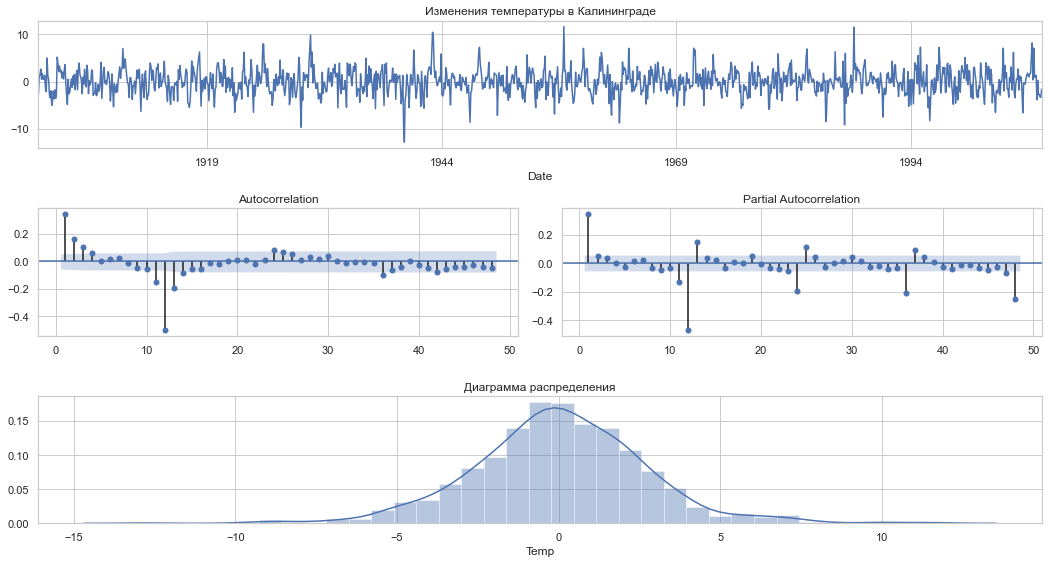

In [16]:
check_stationarity(train['Temp'].diff(12).dropna())

In [17]:
def walk_forward(training_set, validation_set, params):
    '''
    Параметры: это кортеж, в котором мы собрали следующие параметры SARIMA: ((pdq), (PDQS), trend)
    '''
    history = [x for x in training_set.values]
    prediction = list()
    
    pdq, PDQS, trend = params

    for week in range(len(validation_set)):
        model = sm.tsa.statespace.SARIMAX(history, order=pdq, seasonal_order=PDQS, trend=trend)
        result = model.fit(disp=False)
        yhat = result.predict(start=len(history), end=len(history))
        prediction.append(yhat[0])
        history.append(validation_set[week])
        
    return prediction

In [18]:
val['Pred'] = walk_forward(train['Temp'], val['Temp'], ((3,0,0),(0,1,1,12),'c'))

In [19]:
rmse_pred = measure_rmse(val['Temp'], val['Pred'])

print(f"Среднеквадратичное отклонение модели SARIMA(3,0,0),(0,1,1,12),'c' составило {round(rmse_pred,4)} градуса Цельсия")
print(f"Это снижение на среднеквадратичное отклонение равное {round((rmse_pred/rmse_base-1)*100,2)}%")

Среднеквадратичное отклонение модели SARIMA(3,0,0),(0,1,1,12),'c' составило 1.761 градуса Цельсия
Это снижение на среднеквадратичное отклонение равное -55.17%


In [20]:
# Создание столбца ошибок
val['Error'] = val['Temp'] - val['Pred']

In [21]:
def plot_error(data, figsize=(20,8)):
    '''
    Сделаем 3 столбца: Temperature, Prediction, Error
    '''
    plt.figure(figsize=figsize)
    ax1 = plt.subplot2grid((2,2), (0,0))
    ax2 = plt.subplot2grid((2,2), (0,1))
    ax3 = plt.subplot2grid((2,2), (1,0))
    ax4 = plt.subplot2grid((2,2), (1,1))

    ax1.plot(data.iloc[:,0:2])
    ax1.legend(['Real','Pred'])
    ax1.set_title('Current and Predicted Values')

    ax2.scatter(data.iloc[:,1], data.iloc[:,2])
    ax2.set_xlabel('Предсказанные значения')
    ax2.set_ylabel('Ошибки')
    ax2.set_title('Отношение ошибок к предсказанным величинам')

    sm.graphics.qqplot(data.iloc[:,2], line='r', ax=ax3)

    plot_acf(data.iloc[:,2], lags=(len(data.iloc[:,2])-1),zero=False, ax=ax4)
    plt.tight_layout()
    plt.show()

In [22]:
# Удаляем некоторые столбцы для построения графиков
val.drop(['month','year'], axis=1, inplace=True)
val.head()

,Temp,Pred,Error
Date,,,
2008-01-31,4.602,0.741019,3.860981
2008-02-29,3.314,3.381836,-0.067836
2008-03-31,6.459,6.252158,0.206842
2008-04-30,9.661,10.166322,-0.505322
2008-05-31,13.495,13.170459,0.324541


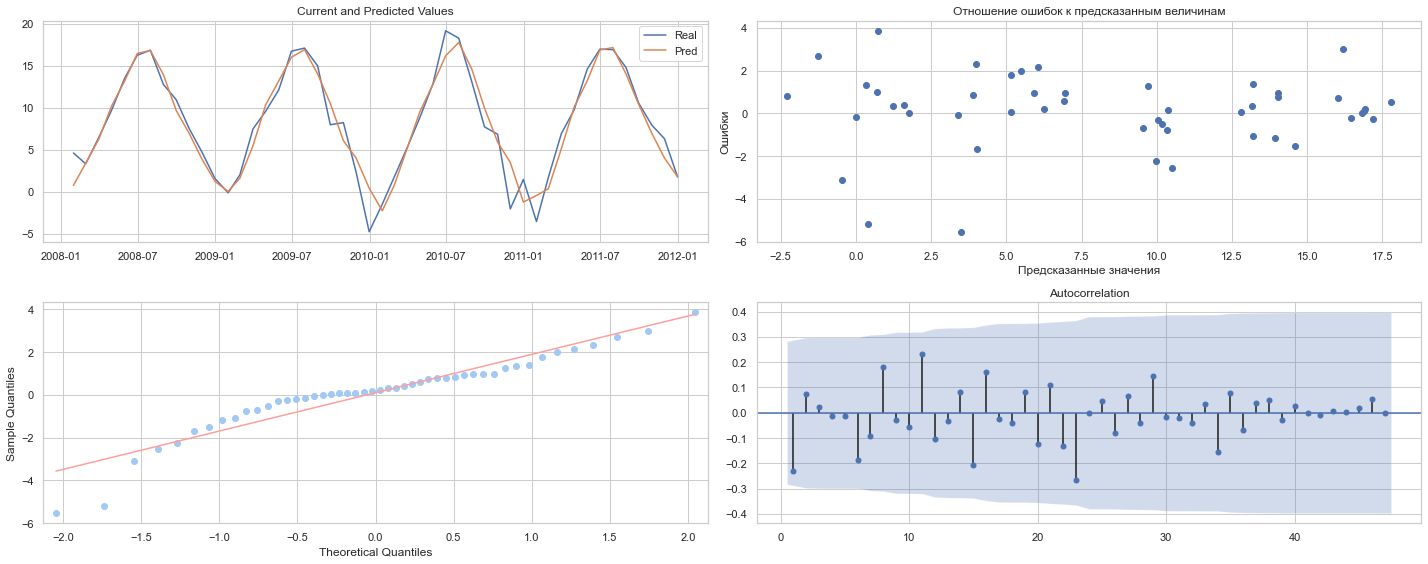

In [23]:
plot_error(val)

In [24]:
# Создание нового конкатенации обучающего и проверочного набора:
future = pd.concat([train['Temp'], val['Temp']])
future.head()

Date
1900-01-31    -1.514
1900-02-28    -1.419
1900-03-31     3.069
1900-04-30     6.756
1900-05-31    12.402
Name: Temp, dtype: float64

In [25]:
# Используем те же параметры подогнанной модели
model = sm.tsa.statespace.SARIMAX(future, order=(3,0,0), seasonal_order=(0,1,1,12), trend='c')
result = model.fit(disp=False)

In [26]:
test['Pred'] = result.predict(start=(len(future)), end=(len(future)+13))

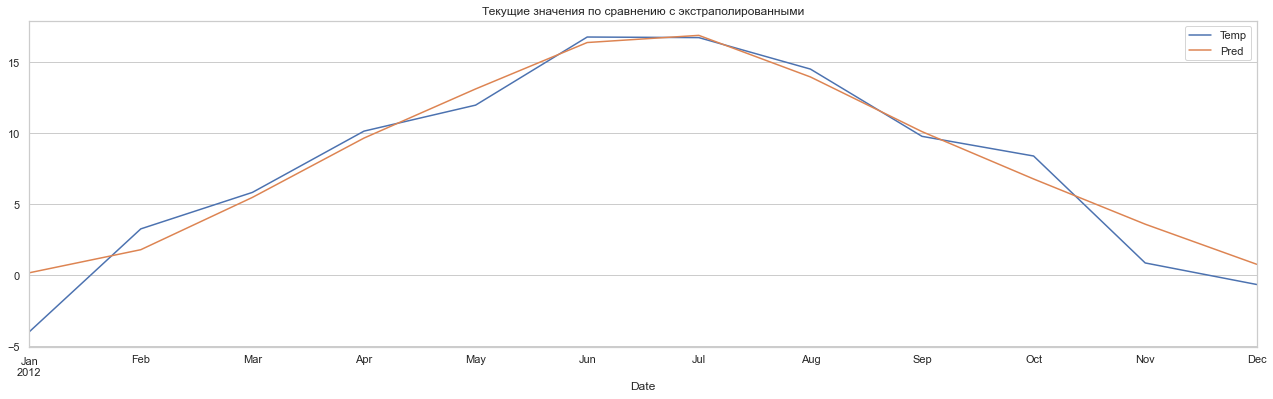

In [27]:
test[['Temp', 'Pred']].plot(figsize=(22,6))
plt.title('Текущие значения по сравнению с экстраполированными')
plt.show()

In [28]:
test_baseline = test['Temp'].shift()

test_baseline[0] = test['Temp'][0]

rmse_test_base = measure_rmse(test['Temp'],test_baseline)
rmse_test_extrap = measure_rmse(test['Temp'], test['Pred'])

print(f'RMSE baseline для теста baseline составило {round(rmse_test_base,2)} градуса Цельсия')
print(f'RMSE baseline для теста экстраполяции составило {round(rmse_test_extrap,2)} градуса Цельсия')
print(f'Улучшение состовляет {-round((rmse_test_extrap/rmse_test_base-1)*100,2)}%')

RMSE baseline для теста baseline составило 4.0 градуса Цельсия
RMSE baseline для теста экстраполяции составило 1.68 градуса Цельсия
Улучшение состовляет 58.09%
